In [4]:
import pandas as pd

fichier = pd.read_csv("export_IA.csv")
print(fichier.head())


    id       MMSI          BaseDateTime       LAT       LON   SOG    COG  \
0   82  636017833  2023-05-29T00:00:06Z  29.07019 -89.29958  13.4  227.6   
1   91  367477280  2023-05-29T00:00:06Z  29.25456 -89.97235   0.0  267.4   
2  119  366954420  2023-05-29T00:00:10Z  27.77637 -82.63027   0.0  265.3   
3  222  367670000  2023-05-29T00:00:05Z  29.13941 -90.20319   0.0  165.1   
4  255  255805583  2023-05-29T00:00:02Z  28.86110 -95.15923   0.1   39.9   

   Heading        VesselName         IMO CallSign  VesselType  Status  Length  \
0      227       STOLT LOTUS  IMO9617648    D5MX5          80       0     183   
1      511              HERO  IMO8964147  WDH2114          60       0      47   
2      294  PROVINCETOWN III  IMO9329394  WDB8185          60       0      30   
3      340    HARVEY AMERICA  IMO9688477     KHAI          70       0      92   
4       64        CHEM SEA 1  IMO9731729     CQTD          80       1     160   

   Width  Draft  Cargo TransceiverClass  
0     28   10.

Nombre de navires uniques : 93
Nombre total de positions : 209089

Entraînement d'un modèle PAR NAVIRE (beaucoup plus pertinent)...

MMSI 205776000 | 2175 positions | Erreur moyenne ≈ 1131.1 m
MMSI 209513000 | 2973 positions | Erreur moyenne ≈ 290.5 m
MMSI 212040000 | 1859 positions | Erreur moyenne ≈ 4.1 m
MMSI 215583000 | 996 positions | Erreur moyenne ≈ 4105.4 m
MMSI 241770000 | 1943 positions | Erreur moyenne ≈ 157.6 m
MMSI 244561000 | 3044 positions | Erreur moyenne ≈ 33.4 m
MMSI 245021000 | 1686 positions | Erreur moyenne ≈ 5.0 m
MMSI 248895000 | 2623 positions | Erreur moyenne ≈ 33.4 m
MMSI 249086000 | 4394 positions | Erreur moyenne ≈ 3.1 m
MMSI 255805583 | 955 positions | Erreur moyenne ≈ 3854.5 m
MMSI 257087080 | 1849 positions | Erreur moyenne ≈ 3.9 m
MMSI 305291000 | 1376 positions | Erreur moyenne ≈ 4.8 m
MMSI 311000808 | 842 positions | Erreur moyenne ≈ 1517.2 m
MMSI 319499000 | 1912 positions | Erreur moyenne ≈ 7.5 m
MMSI 338601000 | 1175 positions | Erreur moyenne ≈ 12.

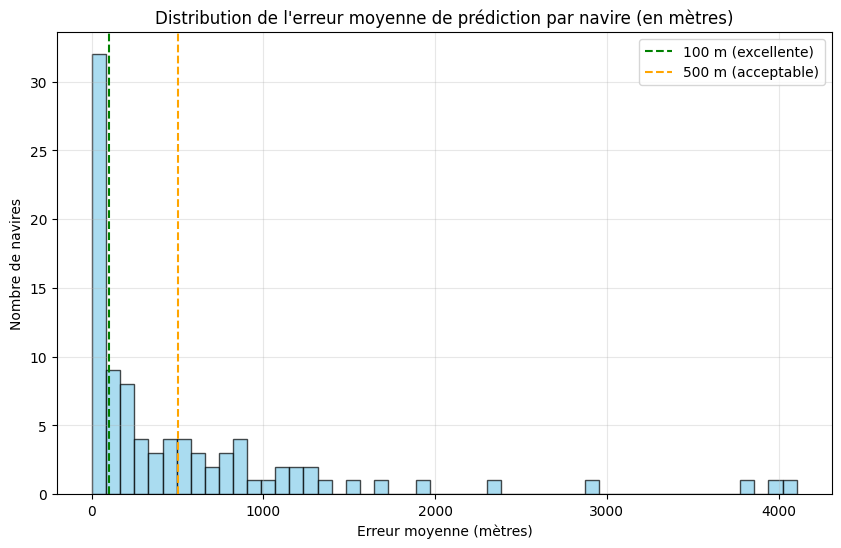

In [1]:
# BESOIN CLIENT 3 - Prédiction de trajectoire (VERSION CORRIGÉE & PRO)

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Chargement des données
fichier = pd.read_csv("export_IA.csv")

# On garde seulement les colonnes utiles
df = fichier[['MMSI', 'BaseDateTime', 'LAT', 'LON', 'SOG']].copy()
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'], utc=True)
df = df.sort_values(['MMSI', 'BaseDateTime'])

print(f"Nombre de navires uniques : {df['MMSI'].nunique()}")
print(f"Nombre total de positions : {len(df)}")

# --- Paramètres ---
sequence_length = 5
erreurs = []

print("\nEntraînement d'un modèle PAR NAVIRE (beaucoup plus pertinent)...\n")

# On entraîne un modèle par navire (seulement ceux qui ont assez de points)
for mmsi, group in df.groupby('MMSI'):
    if len(group) < sequence_length + 1:
        continue
        
    coords = group[['LAT', 'LON']].values
    
    X, y = [], []
    for i in range(len(coords) - sequence_length):
        X.append(coords[i:i+sequence_length].flatten())
        y.append(coords[i+sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    
    # Modèle spécifique à ce navire
    model = LinearRegression()
    model.fit(X, y)
    
    # Prédiction
    pred = model.predict(X)
    
    # Erreur en mètres (approximation)
    # 1° ≈ 111 km → 1e-4° ≈ 11 mètres
    dist_m = np.sqrt(((y - pred) ** 2).sum(axis=1)) * 111000
    erreur_moyenne = dist_m.mean()
    
    erreurs.append({
        'MMSI': mmsi,
        'points': len(group),
        'erreur_moyenne_m': round(erreur_moyenne, 2),
        'erreur_mediane_m': round(np.median(dist_m), 2)
    })
    
    # Afficher seulement les bons / mauvais exemples
    if len(erreurs) <= 5 or erreur_moyenne < 50 or erreur_moyenne > 1000:
        print(f"MMSI {mmsi} | {len(group)} positions | Erreur moyenne ≈ {erreur_moyenne:.1f} m")

# Résultats globaux
df_erreurs = pd.DataFrame(erreurs)
print("\n" + "="*60)
print("RÉSULTATS GLOBAUX")
print("="*60)
print(f"Navires modélisés : {len(df_erreurs)}")
print(f"Erreur moyenne (tous navires) : {df_erreurs['erreur_moyenne_m'].mean():.1f} mètres")
print(f"Erreur médiane : {df_erreurs['erreur_mediane_m'].median():.1f} mètres")
print(f"Meilleure prédiction : {df_erreurs['erreur_moyenne_m'].min():.1f} m")
print(f"Pire prédiction : {df_erreurs['erreur_moyenne_m'].max():.1f} m")

# Distribution des erreurs
plt.figure(figsize=(10,6))
plt.hist(df_erreurs['erreur_moyenne_m'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Distribution de l'erreur moyenne de prédiction par navire (en mètres)")
plt.xlabel("Erreur moyenne (mètres)")
plt.ylabel("Nombre de navires")
plt.axvline(100, color='green', linestyle='--', label="100 m (excellente)")
plt.axvline(500, color='orange', linestyle='--', label="500 m (acceptable)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()